# Hybrid Switching  
  
The Hybrid Switching solver is designed to allow a model's species to be represented dynamically as either continuous or stochastic throughout the simulation.  This solver will represent a reaction channel deterministically at high populations in order to favor performance, and will automatically switch to a stochastic representation at lower populations.  This allows for substantial run-time improvements over the SSA, minimizing the loss of stochastic accuracy.  
  
There is no special setup for the standard case of using this switching mechanism, however for cases where a particular species should always be represented as 'stochastic' or always represented as 'continuous,' the GillesPy2.species can be constructed with kwarg 'mode' locking that into place.  
  
  
**mode='dynamic'(default) - allows for hybrid switching  
mode='continuous' - forces a species to be modeled continuously/deterministically  
mode='discrete' - forces a species to be modeled discretely/stochastically**  
  
Ex:  
A = GillesPy2.Species(name='A', initial_value=400, mode='continuous')

In [1]:
import sys, os
import numpy
import matplotlib.pyplot as plt
plt.style.use('dark_background')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
sys.path.append('../../../')

In [2]:
import gillespy2
from gillespy2.solvers.numpy.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.solvers.numpy.ssa_solver import NumPySSASolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

In [3]:
class AutomaticSwitchExample(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Automatic Switch Example")
            
            #parameters
            k1 = gillespy2.Parameter(name='k1', expression= 3e-4)
            k2 = gillespy2.Parameter(name='k2', expression= .5e-2)
            k3 = gillespy2.Parameter(name='k3', expression = 2e-1)
            self.add_parameter([k1,k2,k3])
            
            #Species
            A = gillespy2.Species(name='A', initial_value=400)
            B = gillespy2.Species(name='B', initial_value=10000)
            C = gillespy2.Species(name='C', initial_value=10000)
            self.add_species([A, B, C])
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={B:1,C:1},
                   rate=k1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={B:1}, products={},
                    rate=k2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={A:1},
                    rate=k3)

            self.add_reaction([r1,r2,r3])
            self.timespan(numpy.linspace(0,600,601))

In [4]:
model = AutomaticSwitchExample()
results = {}

In [5]:
%time tau_hybrid_results = model.run(solver=BasicTauHybridSolver, stoch_kit_home='test')

2019-07-17 17:15:58,209 - root - WARNING - Unsupported keyword argument to solver: stoch_kit_home


CPU times: user 16.5 s, sys: 1.02 s, total: 17.6 s
Wall time: 16.3 s


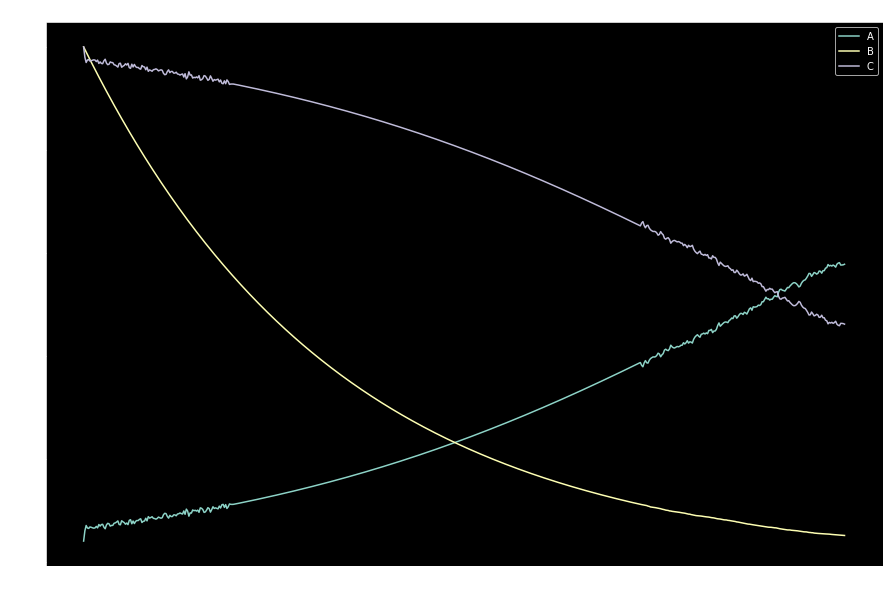

In [6]:
plt.figure(figsize=(15, 10))
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='{0}'.format(species))
plt.title('Example Hybrid Switching Model')
plt.legend(loc='best')

The hybrid switching condition is based on a coefficient of variance for each species.  The error threshhold for this condition can be user modified by instantiating the solver, and calling the run function from it, rather than the solver.  
  
The default value is .003 and is a threshold to the coefficient of variance for each species at the selected forward step (t + tau).  Because of this relationship to the selected tau, this value may need to be adjusted when adjusting the tau_tol during a simulation (larger tau_tol / tau steps will result in greater variance, and subsequently requires a higher switch tolerance).

In [7]:
%time results2 = model.run(solver=BasicTauHybridSolver, switch_tol=1)

CPU times: user 12 s, sys: 1.23 s, total: 13.2 s
Wall time: 11.6 s


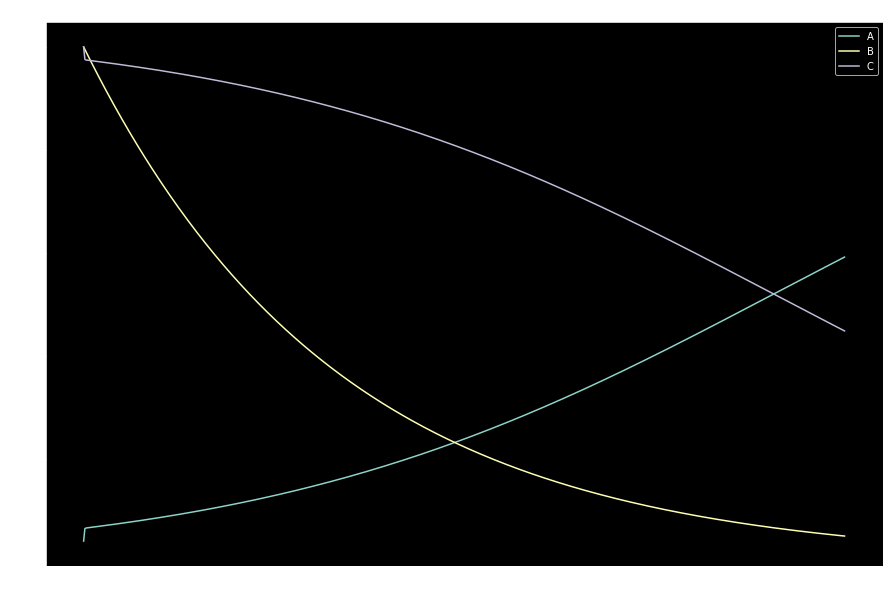

In [8]:
plt.figure(figsize=(15, 10))
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='{0}'.format(species))
plt.title('Example Hybrid Switching Model')
plt.legend(loc='best')

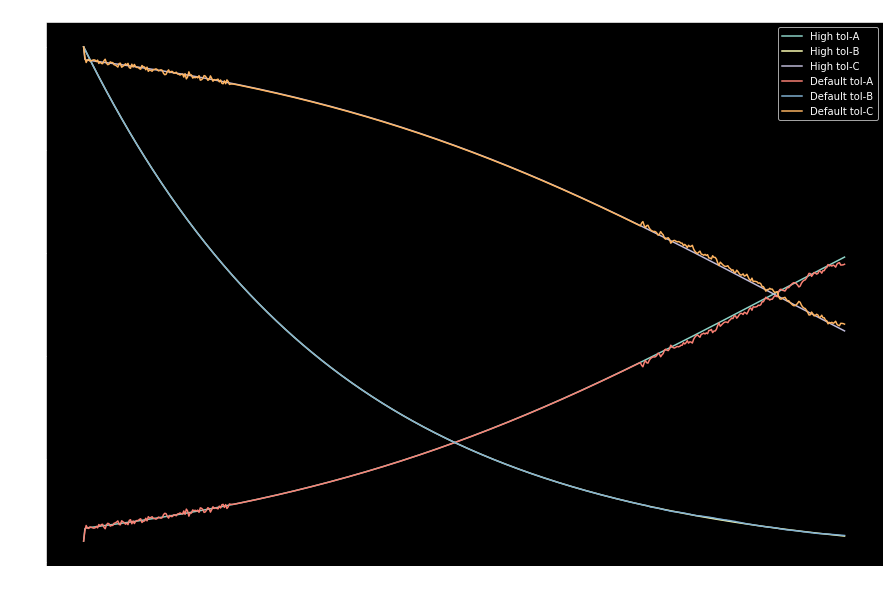

In [9]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results default vs higher tolerance')
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='High tol-{0}'.format(species))
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='Default tol-{0}'.format(species))
    plt.legend(loc='best')

Additionally, both the hybrid_tol and tau_tol can be modified to result in extremely fast simulations.

In [10]:
%time results3 = model.run(solver=BasicTauHybridSolver, switch_tol=.03, tau_tol=0.05)

CPU times: user 10.3 s, sys: 594 ms, total: 10.9 s
Wall time: 10 s


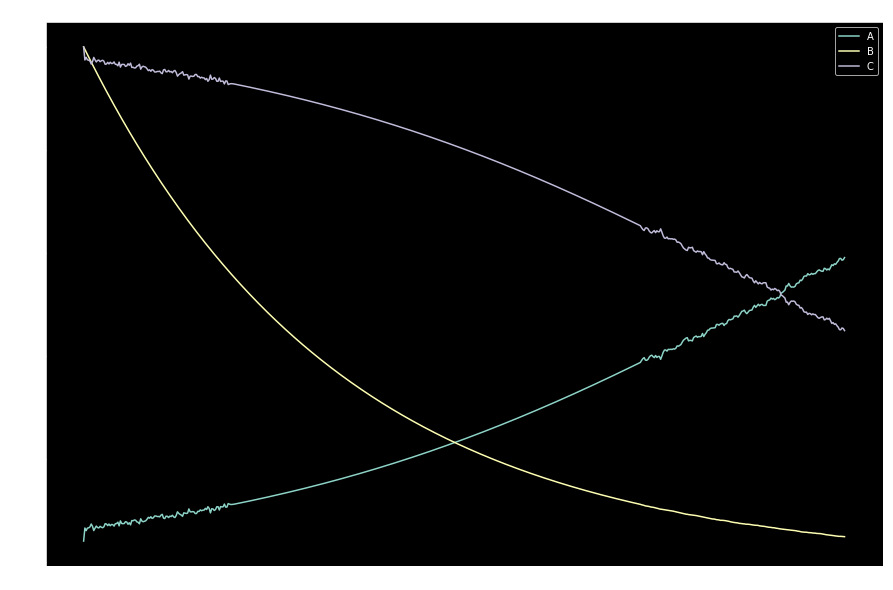

In [11]:
plt.figure(figsize=(15, 10))
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='{0}'.format(species))
plt.title('Example Hybrid Switching Model')
plt.legend(loc='best')

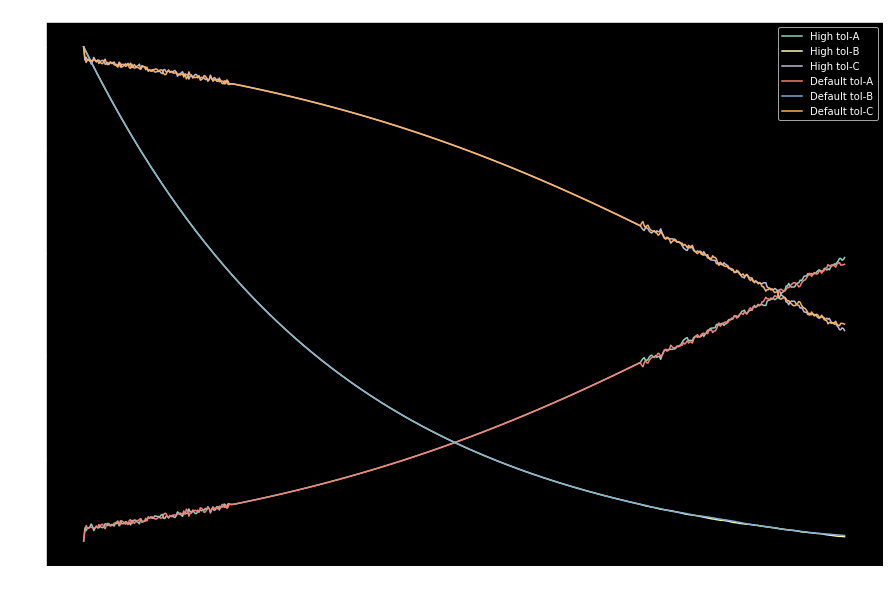

In [12]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results default vs higher tau + hybrid tolerance')
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='High tol-{0}'.format(species))
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='Default tol-{0}'.format(species))
    plt.legend(loc='best')

In [13]:
%time results2 = model.run()

CPU times: user 46.9 ms, sys: 250 ms, total: 297 ms
Wall time: 10.5 s


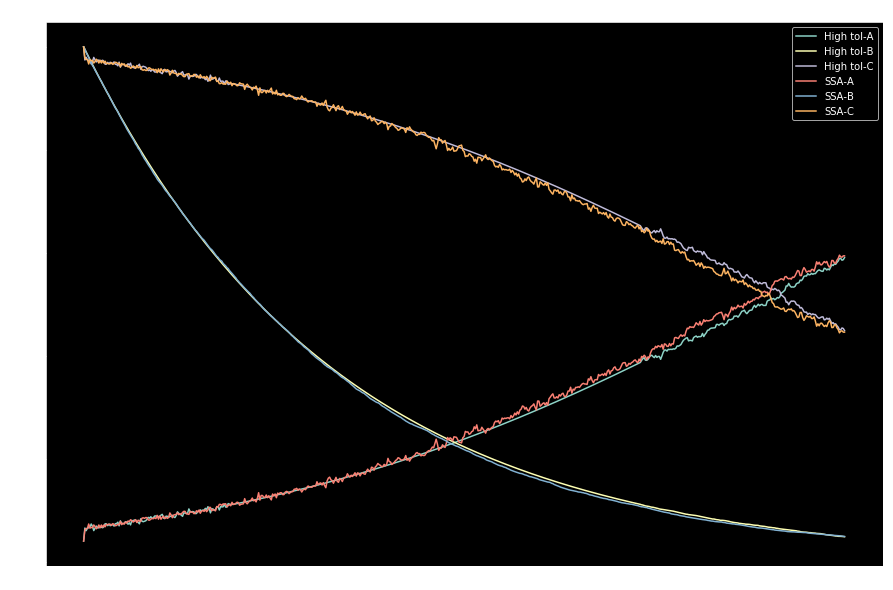

In [14]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results SSA vs higher tau + hybrid tolerance')
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='High tol-{0}'.format(species))
for species in results2[0]:
    if species == 'time': continue
    plt.plot(results2[0]['time'], results2[0][species], label='SSA-{0}'.format(species))
    plt.legend(loc='best')

In [15]:
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

In [16]:
results4 = model.run(solver=BasicODESolver)

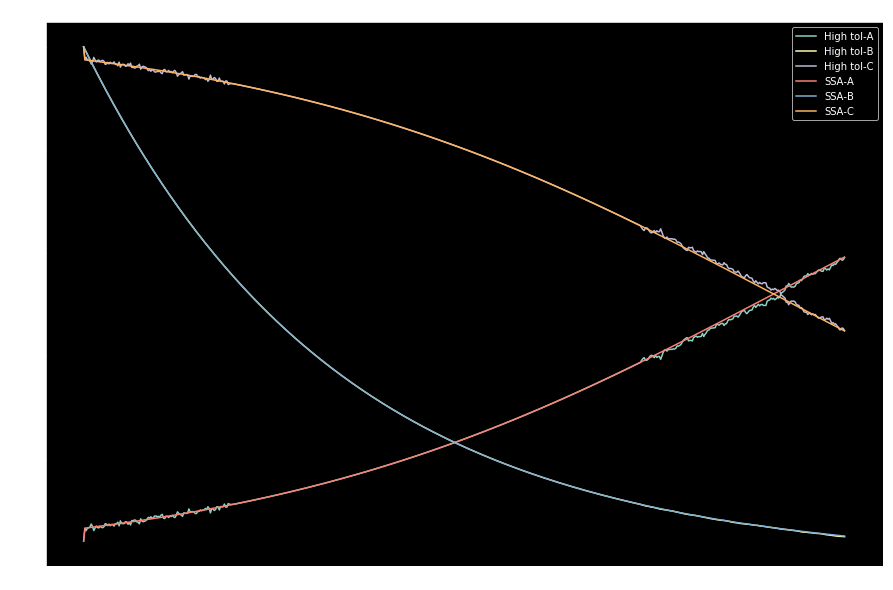

In [17]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results SSA vs higher tau + hybrid tolerance')
for species in results3[0]:
    if species == 'time': continue
    plt.plot(results3[0]['time'], results3[0][species], label='High tol-{0}'.format(species))
for species in results4[0]:
    if species == 'time': continue
    plt.plot(results4[0]['time'], results4[0][species], label='SSA-{0}'.format(species))
    plt.legend(loc='best')